# Numerical simulation of SDEs

This is a reproduction of certain scripts found in Higham, *An algorithmic Introduction to Numerical Simulation of Stochastic Differential Equations.*{cite}`higham` This paper is an accessible introduction to SDEs, which is centered around ten MATLAB scripts. Below are reproductions of these scripts (excluding two on linear stability) and some supplementary notes.

## Why Stochastic differential equations

We are often interested in modelling a system whose state takes values in a continuous range, and over a continuous time domain. Whereas ordinary differential equations (ODEs) describe variables which change according to a deterministic rule, SDEs describe variables whose change is governed partly by a deterministic component and partly by a stochastic component. SDEs are therefore an appropriate model for systems whose dynamics involve some true randomness, or some fine grained complexity which we cannot afford to or do not wish to model.

In [137]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## The Wiener process

In order to define the stochastic component of the transition rule of a stochastic system, we must define an appropriate noise model. The Wiener process is a stochastic process that is commonly used for this purpose.

<div class="definition">
    
**Definition (Wiener process)** A *standard Wiener process* over [0, T] is a random variable $W(t)$ that depends continuously on $t \in [0, T]$ and satisfies:

1. W(0) = 0, with probability 1.
2. For $0 \leq t_1 < t_2 \leq T$ the random variable $W(t_2) - W(t_1)$ has distribution $\mathcal{N}(0, t_2 - t_1)$.
3. For $0 \leq t_1 < t_2 < t_3 < t_4 \leq T$, the random variables $W(t_2) - W(t_1)$ and $W(t_4) - W(t_3)$ are independent.
    
</div>

<br>

We can imagine the Wiener process as the path followed by a particle that experiences infinitely many, infinitesimal kicks. The size of these kicks, $W(t_2) - W(t_1)$, diminishes as the interval between them, $t_2 - t_1$, diminishes. The kicks are also independent from each other, so the future path of the particle is independent of its past path given its present position.

## Sampling from a Wiener process

Before using the Wiener process to define an SDE, let's look at the process itself. How can we draw a sample $W(t)$ from it? Since a sample from the Wiener process takes a random value for every $t \in [0, \infty)$, the best we can do on a computer is to sample the process at a finite subset of time instances. We specify the times $t_1 < t_2 < ... < t_N$ at which to sample $W(t)$, and then use the definition of the Wiener process to see that we should sample as follows:

$$\begin{align}
W(t_{n+1}) = W(t_{n}) + \Delta W(t_{n}), \text{ where } \Delta W(t_{n}) \sim \mathcal{N}(0, t_{n+1} - t_n),
\end{align}$$

where $W(t_0) = W(0) = 0$. We can therefore sample all the $\Delta W(t_n)$ independently, and take their cumulative sum to compute $W(t_n)$, as shown below.

In [139]:
# Set random seed
np.random.seed(0)

# Integration parameters
T = 1
N = 500
dt = T / N

# Times to sample at
t = np.linspace(0, T, N)[:, None]

# Sample dW's and compute cumulative sum
dW = dt ** 0.5 * np.random.normal(size=(N - 1, 1))
W = np.concatenate([[0], np.cumsum(dW)])

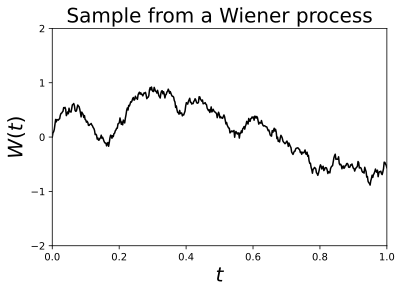

In [140]:
plt.figure(figsize=(6, 4))
plt.plot(t, W, color='k')

plt.xticks(np.linspace(0, T, 6))
plt.yticks(np.linspace(-2, 2, 5))
plt.xlim([0, 1])
plt.ylim([-2, 2])

plt.title('Sample from a Wiener process', fontsize=20)
plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(r'$W(t)$', fontsize=20)
plt.show()

So even though we can't represent the entirety of the path, we can sample it to arbitrary precision.

## Function of a Wiener process

Suppose we are interested in a stochastic process which is a function of a Wiener process, say

$$\begin{align}
X(t) = \exp\left(t + \frac{1}{2}W(t)\right).
\end{align}$$

In this case we can sample $X(t)$ by first sampling $W(t)$, and then computing the corresponding values of $X(t)$. We'll draw `S = 1000` samples of $X(t)$, compute their mean, standard deviation and show three of these samples.

In [141]:
# Set random seed 
np.random.seed(0)

# Time to simulate for, discretisation level and number of paths
T = 1
N = 500
S = 1000
dt = T / N

# Times to sample at
t = np.linspace(0, T, N)

# Sample dW's and compute cumulative sum
dW = dt ** 0.5 * np.random.normal(size=(N - 1, S))
W = np.concatenate([np.zeros(shape=(1, S)), np.cumsum(dW, axis=0)], axis=0)

# Compute values 
X = np.exp(t[:, None] + 0.5 * W)
X_mean = np.mean(X, axis=1)
X_stdev = np.var(X, axis=1) ** 0.5

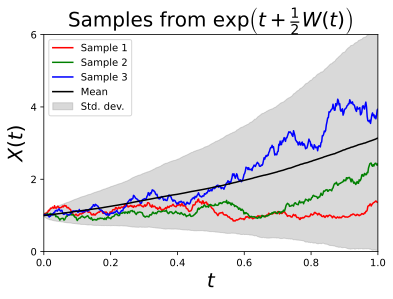

In [142]:
plt.figure(figsize=(6, 4))
plt.plot(t, X[:, 0], color='r', label='Sample 1')
plt.plot(t, X[:, 1], color='g', label='Sample 2')
plt.plot(t, X[:, 2], color='b', label='Sample 3')

plt.plot(t, X_mean, color='k', label='Mean')
plt.fill_between(t,
                 X_mean - 2 * X_stdev,
                 X_mean + 2 * X_stdev,
                 color='gray',
                 alpha=0.3,
                 label='Std. dev.')

plt.xticks(np.linspace(0, T, 6))
plt.yticks(np.linspace(0, 6, 4))
plt.xlim([0, 1])
plt.ylim([0, 6])

plt.title(r'Samples from $\exp\left(t + \frac{1}{2} W(t)\right)$', fontsize=20)
plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(r'$X(t)$', fontsize=20)
plt.legend()
plt.show()

## Evaluating a stochastic integral

The next thing that we look at is the evaluation of a stochastic integral. Let's consider the integral

$$\begin{align}
Y = \int^1_0 W(t)~dW(t),
\end{align}$$

where $W(t)$ is a Wiener process. To evaluate it, we first need to define what the $\int$ means in the stochastic case. In the deterministic case we use Riemann integral, which is the limit of a discretised sum:

$$\begin{align}
R = \int^b_a f(t)~dt = \lim_{N \to \infty} \sum_{n = 0}^{N - 1} f\left(a + n\delta t\right) \delta t
\end{align}$$

where $\delta t = \frac{b - a}{N}$. We have chosen to evaluate $f$ on the left side of the discretisation bins. In the deterministic case, it does not matter where we evaluate $f$ within a discretisation bin, meaning that the integral

$$\begin{align}
R_\lambda = \lim_{N \to \infty} \sum_{n = 0}^{N - 1} f\left(a + \left(n + \lambda\right) \delta t\right) \delta t,
\end{align}$$

does not depend on the choice of $\lambda \in [0, 1]$ when we take $\delta t \to 0$ (provided $f$ is sufficiently well behaved). For stochastic integrals, this does not hold: the choice of where to evaluate the integrand affects the value of the integral, even in the limit $\delta t \to 0$ - we will see an example from Higham shortly. We therefore have to make a choice in defining the integral. Two widespread choices are the Ito and the Stratonovich integrals:

$$\begin{align}
&\int^b_a h(t) dW(t) = \lim_{N \to \infty} \sum_{n = 0}^{N - 1} h(t_n) \left(W(t_{n + 1}) - W(t_n)\right), \text{ Ito}.\\
\\
&\int^b_a h(t) dW(t) = \lim_{N \to \infty} \sum_{n = 0}^{N - 1} h\left(\frac{t_n + t_{n+1}}{2}\right) \left(W(t_{n + 1}) - W(t_n)\right), \text{ Stratonovich}.
\end{align}$$

where we have defined $t_n = a + n \delta t$. While Ito evaluates the integrand on the left side of the discretisation bin ($\lambda = 0$), Stratonovich evaluates it at the midpoint of the bin ($\lambda = 1/2$). Our stochastic integral of interest

$$\begin{align}
Y = \int^1_0 W_t~dW_t,
\end{align}$$

is equal to the following values under the Ito and Stratonovich definitions:

$$\begin{align}
\int^1_0 W_t~dW_t = \begin{cases}
\frac{1}{2}W(T)^2 - \frac{1}{2}T^2 & \text{ under Ito,}\\
\frac{1}{2}W(T)^2 & \text{ under Stratonovich.}
\end{cases}
\end{align}$$

<br>

<details class="proof">
<summary>Evaluating \(\int W(t)~dW(t)\) under the Ito and Stratonovich integrals</summary>

<div>
    
If we use the Ito integral, we have
    
$$\begin{align}
\sum_{n = 0}^{N - 1} W(t_n) \left(W(t_{n + 1}) - W(t_n)\right) &= \frac{1}{2}\sum_{n = 0}^{N - 1} \left( W(t_{n + 1})^2 - W(t_n)^2 - (W(t_{n + 1}) - W(t_n))^2 \right)\\
&= \frac{1}{2}\left(  W(T)^2 - W(0)^2 - \sum_{n = 0}^{N - 1} (W(t_{n + 1}) - W(t_n))^2 \right).
\end{align}$$
    
The distribution of $(W(t_{n + 1}) - W(t_n))^2$ has mean equal to the second moment of $\Delta W_{t_n}$ and variance equal to the fourth moment of $\Delta W_{t_n}$, which are $\delta t$ and $3 \delta t^2$ respectively. Therefore, the sum above is a random variable with mean $T$ and variance $\mathcal{O}(\delta t)$ - where we have used the fact that the summands are independent, so the variance of the sum is the sum of the variances. So in the limit of $\delta t \to 0$, the integral converges to $\frac{1}{2}W(T)^2 - \frac{1}{2}T^2$ under the Ito definition.
    
By contrast, if we use the Stratonovich integral, we have
    
$$\begin{align}
\sum_{n = 0}^{N - 1} W\left(\frac{t_{n+1} + t_n}{2}\right) \left(W(t_{n + 1}\right) - W(t_n)) &= \sum_{n = 0}^{N - 1} \left(\frac{W(t_{n + 1}) + W(t_n)}{2} + \Delta Z_n\right) \left(W(t_{n + 1}\right) - W(t_n))\\
&= \sum_{n = 0}^{N - 1} \frac{1}{2} W(t_{n + 1})^2 - \frac{1}{2} W(t_n)^2 + \Delta Z_n \left(W(t_{n + 1}\right) - W(t_n))\\
&= \frac{1}{2} W(T)^2 - \frac{1}{2} W(0)^2 + \sum_{n = 0}^{N - 1} \Delta Z_n \left(W(t_{n + 1}\right) - W(t_n)),
\end{align}$$
    
where $\Delta Z_n \sim \mathcal{N}(0, \delta t / 4)$. To obtain the first equality above, we used the fact that
    
$$\begin{align}
p\left(W\left(\frac{t_{n+1} + t_n}{2}\right)\big |~ W(t_{n+1}), W(t_{n})\right) = \frac{p\left( W(t_{n+1}) | W\left(\frac{t_{n+1} + t_n}{2}\right)\right) p\left( W\left(\frac{t_{n+1} + t_n}{2}\right) \big | W(t_{n}) \right) p(W(t_n))}{p(W(t_{n+1}), W(t_{n}))},\\
\end{align}$$
    
and observing that the distribution above has the form of a product of normal distributions over $W\left(\frac{t_{n+1} + t_n}{2}\right)$, we arrive at the result:
    
$$\begin{align}
p\left(W\left(\frac{t_{n+1} + t_n}{2}\right)\big |~ W(t_{n+1}), W(t_{n})\right) = \mathcal{N}\left(W\left(\frac{t_{n+1} + t_n}{2}\right); \frac{W(t_{n+1}) + W(t_{n})}{2}, \frac{\delta t}{4}\right).
\end{align}$$
    
Since $\Delta Z_n$ is independent of $W_t$, the term $\Delta Z_n \left(W(t_{n + 1}\right) - W(t_n))$ has mean 0, and variance $\delta t^2 / 4$. Therefore, the sum term has mean 0 and variance $\mathcal{O}(\delta t)$, so in the limit of $\delta t \to 0$ the integral converges to $\frac{1}{2}W(T)^2$ under the Stratonovich definition.
 
</div>

</details>
<br>

In [143]:
# Set random seed
np.random.seed(3)

# Time to simulate for and discretisation level
T = 1
N = int(1e6)
dt = T / N

# Sample dW's and compute cumulative sum
dW = dt ** 0.5 * np.random.normal(size=(N,))
W = np.concatenate([[0], np.cumsum(dW)])

# Evaluate the Ito integral
ito_approx = np.sum(W[:-1] * dW)
ito_exact = 0.5 * W[-2] ** 2 - 0.5 * T

# The Wiener process must be evaluated at the midpoints to evaluate the Stratonovich integral
W_midpoint = (W[:-1] + W[1:]) / 2
W_midpoint = W_midpoint + np.random.normal(0, (dt / 4) ** 0.5, size=(N,))

# Evaluate the Stratonovich integral
strat_approx = np.sum(W_midpoint * dW)
strat_exact = 0.5 * W[-2] ** 2

print(f'Ito integral approximation (exact): {ito_approx:.3f} ({ito_exact:.3f})')
print(f'Stratonovich approximation (exact): {strat_approx:.3f} ({strat_exact:.3f})')

Ito integral approximation (exact): 1.419 (1.415)
Stratonovich approximation (exact): 1.917 (1.915)


The difference between the Ito and Stratonovich integrals does not vanish as $dt \to 0$, which you can verify by experimenting with $dt$ above. The choice of definition has implications about the resulting integral (itself a stochastic process), which may be more or less appropriate for different applications. From here onwards we will work with the Ito integral exclusively, although much of the discussion is ammenable to the Stratonovich integral too.

## Euler-Maruyama method

The Euler-Maruyama method is the analoge of the Euler method for deterministic integrals, applied to the stochastic case.

<div class="definition">
    
**Definition (Euler-Maruyama method)** Given a scalar SDE with drift and diffusion functions $f$ and $g$
    \begin{align}dX(t) = f(X(t))dt + g(X(t)) dW(t),\end{align}
    the Euler-Maruyama method approximates $X$ by
    \begin{align} X_{n + 1} = X_n + f(X_n) \Delta t + g(X_n) \Delta W_n,\end{align}
    where $\delta t > 0$ is the time step, $X_n = X(t_n), W_n = W(t_n)$ and $t_n = n\delta t$.
    
</div>
<br>

Let's look at an implementation of the Euler-Maruyama (EM) method. The `euler_maruyama` below function takes the *drift* and *diffusion* functions $f$, $g$ and applies the EM algorithm (not to be confused with Expectation Maximisation), from the specified initial conditions. Note that we can sample the `dW` in advance.

In [59]:
def euler_maruyama(seed, X0, T, N, f, g):
    
    # Set random seed
    np.random.seed(seed)
    
    # Set discretisation, initial value and times at which to evaluate
    dt = T / N
    X = [X0]
    t = np.linspace(0, T, N + 1)
    
    # Sample Wiener process dW's
    dW = dt ** 0.5 * np.random.normal(size=(N,))
    
    for i in range(N):
        
        # Apply Euler-Maruyama at each point in time
        dX = f(X[-1], t[i]) * dt + g(X[-1], t[i]) * dW[i]
        
        # Store the new X
        X.append(X[-1] + dX)
    
    # Compute W to return it at the end
    W = np.concatenate([[0], np.cumsum(dW)])
    
    return t, X, W

Below is the definition of `f` and `g` that we will be integrating, namely

$$\begin{align}
f(x, t) &= \lambda x,\\
g(x, t) &= \mu x,\\
\end{align}$$

known as the Black-Scholes model. This is implemented as a closure, i.e. `f_g_black_scholes` takes in the appropriate `lambda` and `mu` and returns the corresponding `f` and `g`.

In [60]:
def f_g_black_scholes(lamda, mu):
    
    def f(X, t):
        return lamda * X
    
    def g(X, t, grad=False):
        return mu if grad else mu * X
    
    return f, g

We choose these drift and diffusion terms because the associated SDE has a closed form solution, with which we can compare our numerical solution. The analytic solution to the Black-Scholes model is

$$\begin{align}
X_t = X_0 \exp \left[\Big(\lambda - \frac{1}{2} \mu^2\Big)~t + \mu W(t)\right],
\end{align}$$

which we implement in `exact_black_scholes` below. Unlike ODEs, whose solution is a unique function, the solution of an SDE depends on the random noise sample $W(t)$. It's important to remember to share the same $W(t)$ sample between the exact solution and its numerical approximation.

In [61]:
def exact_black_scholes(X0, t, W, lamda, mu):
    return X0 * np.exp((lamda - 0.5 * mu ** 2) * t + mu * W)

We are can now run the EM method and compare it aginst the exact solution below.

In [103]:
# Black-Scholes parameters
lamda = 2
mu = 1

# Seed and integration parameters
seed = 0
X0 = 1
T = 1
N = int(1e2)

# Get drift and diffusion functions of the Black-Scholes model
f, g = f_g_black_scholes(lamda=lamda, mu=mu)

# Solve approximately via the EM method
t, X, W = euler_maruyama(seed=seed, X0=X0, T=T, N=N, f=f, g=g)

# Get the exact solution for the same W sample
X_exact = exact_black_scholes(X0=X0, t=t, W=W, lamda=lamda, mu=mu)

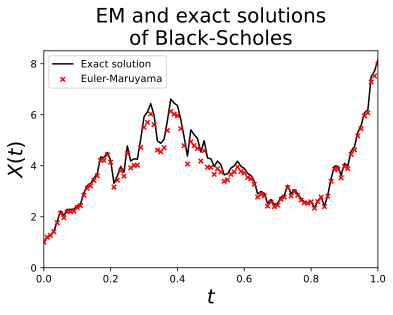

In [104]:
plt.figure(figsize=(6, 4))
plt.plot(t, X_exact, color='k', zorder=1, label='Exact solution')
plt.scatter(t, X, s=20, marker='x', color='red', zorder=2, label='Euler-Maruyama')

plt.xlim([0, T])
plt.xticks(np.linspace(0, 1, 6))
plt.yticks(np.linspace(0, 8, 5))
plt.title('EM and exact solutions\nof Black-Scholes', fontsize=20)
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$X(t)$', fontsize=20)
plt.legend()
plt.show()

We can change the accuracy of the solution by adjusting $N$. As a fun aside, what if we try out a different drift term? One nice choice is

$$\begin{align}
f(x, t) &= \omega~\text{cos}(\omega t),\\
g(x, t) &= \mu x.\\
\end{align}$$

In the case $\mu = 0$, the solution is the deterministic function $X_t = \text{sin}(\omega t)$. When $\mu \neq 0$, the solution will be perturbed by the gaussian noise.

In [99]:
def f_g_sine(omega, mu):
    
    def f(X, t):
        return omega * np.cos(omega * t)
    
    def g(X, t):
        return mu * X
    
    return f, g

In [100]:
# SDE parameters
omega = 2. * np.pi
mu = 0.3

# Seed and integration parameters
seed = 0
X0 = 1
T = 2
N = int(1e3)

# Get drift and diffusion functions of our sine model
f, g = f_g_sine(omega=omega, mu=mu)

# Solve approximately via the EM method
t, X, W = euler_maruyama(seed=seed, X0=X0, T=T, N=N, f=f, g=g)

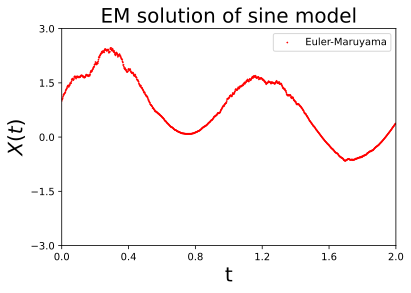

In [102]:
plt.scatter(t, X, s=1, marker='x', color='red', zorder=2, label='Euler-Maruyama')

plt.xlim([0, T])
plt.xticks(np.linspace(0, T, 6))
plt.yticks(np.linspace(-3, 3, 5))
plt.title('EM solution of sine model', fontsize=20)
plt.xlabel('t', fontsize=20)
plt.ylabel('$X(t)$', fontsize=20)
plt.legend()
plt.show()

## Strong and weak convergence

Since the choice of the number of bins $N$ of the discretisation affects the accuracy of our method, we are interested in how quickly the approximation converges to the exact solution as a function of $N$. To do so, we must first define *what convergence means* in the stochastic case, which leads us to two disctinct notions of convergence, the strong sence and the weak sense.

<div class="definition">
    
**Definition (Strong convergence)** A method for approximating a stochastic process $X(t)$ is said to have strong order of convergence $\gamma$ if there exists a constant such that
    \begin{align}\mathbb{E}|X_n - X(\tau_n)| \leq C\Delta t^\gamma\end{align}
    for any fixed $\tau_n = n\Delta t \in [0, T]$ and $\Delta t$ sufficiently small.

</div>
<br>

Strong convergence refers to the rate of convergence of the approximation $X_n$ to the exact solution $X(\tau_n)$ as $\Delta t \to 0$, in expectation. A weaker condition for convergence is rate at which the expected value of the approximation converges to the true expected value, as $\Delta t \to 0$, as given below.

<div class="definition">
    
**Definition (Weak convergence)** A method for approximating a stochastic process $X(t)$ is said to have weak order of convergence $\gamma$ if there exists a constant such that
    \begin{align}|\mathbb{E}[X_n] - \mathbb{E}[X(\tau_n)]| \leq C\Delta t^\gamma\end{align}
    for any fixed $\tau_n = n\Delta t \in [0, T]$ and $\Delta t$ sufficiently small.

</div>
<br>

The paper states without proof that, under conditions on $f$ and $g$, Euler-Maruyama has strong order of convergence $\frac{1}{2}$ and weak order of convergence $1$. We do not provide a proof for any of the above statements, but instead evaluate the rate of convergence empirically. To speed up the evaluation, we implement a function that evaluates several EM solutions in parallel below.

In [ ]:
def parallel_euler_maruyama(seed, num_paths, X0, T, N, f, g):
    
    # Set the random seed
    np.random.seed(seed)
    
    # Time increment
    dt = T / N
    
    # Set initial X values
    X = X0 * np.ones(shape=(num_paths, N + 1))
    
    # Times at which to evaluate the integral
    t = np.linspace(0, T, N + 1)
    
    # Wiener process samples
    dW = dt ** 0.5 * np.random.normal(size=(num_paths, N))
    
    for i in range(N):
        
        # Calculate new X according to EM rule
        X[:, i+1] = X[:, i] + f(X[:, i], t[i]) * dt + g(X[:, i], t[i]) * dW[:, i]
        
    W = np.concatenate([np.zeros(shape=(num_paths, 1)), np.cumsum(dW, axis=1)], axis=1)
    
    return t, X, W

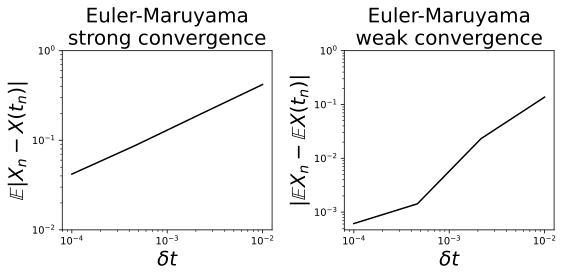

In [121]:
# Black-Scholes parameters
lamda = 2
mu = 1

# Seed and integration parameters
seed = 0
X0 = 1
T = 1
Ns = (10 ** np.linspace(2, 4, 4)).astype(dtype=np.int)
num_paths = int(1e4)

# Get drift and diffusion functions of the Black-Scholes model
f, g = f_g_black_scholes(lamda=lamda, mu=mu)

dts = []
X_approx = []
X_exacts = []

for N in Ns:
    
    t, X, W = parallel_euler_maruyama(seed=seed, num_paths=num_paths, X0=X0, T=T, N=N, f=f, g=g)
    X_exact = exact_black_scholes(X0=X0, t=t[None, :], W=W, lamda=lamda, mu=mu)
    
    dts.append(T / N)
    X_approx.append(X[:, -1])
    X_exacts.append(X_exact[:, -1])
    
X_approx = np.stack(X_approx, axis=0)
X_exacts = np.stack(X_exacts, axis=0)

X_abs_diffs = np.abs(X_approx - X_exacts)
em_strong_errors = np.mean(X_abs_diffs, axis=1)

X_approx_means = np.mean(X_approx, axis=-1)
X_exacts_means = np.mean(X_exacts, axis=-1)
em_weak_errors = np.abs(X_approx_means - X_exacts_means)

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.plot(dts, em_strong_errors, color='k')

plt.loglog()
plt.yticks([1e-2, 1e-1, 1e0])
plt.xlabel(r'$\delta t$', fontsize=20)
plt.ylabel(r'$\mathbb{E}|X_n - X(t_n)|$', fontsize=20)
plt.title('Euler-Maruyama\nstrong convergence', fontsize=20)

plt.subplot(122)
plt.plot(dts, em_weak_errors, color='k')

plt.loglog()
plt.yticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlabel(r'$\delta t$', fontsize=20)
plt.ylabel(r'$|\mathbb{E}X_n - \mathbb{E}X(t_n)|$', fontsize=20)
plt.title('Euler-Maruyama\nweak convergence', fontsize=20)

plt.tight_layout()
plt.show()

## Milstein's higher order method

Just as higher order methods for ODEs exist for obtaining refined estimates of the solution, so do methods for SDEs, such as Milstein's higher order method.

<div class="definition">
    
**Definition (Milstein's method)** Given a scalar SDE with drift and diffusion functions $f$ and $g$
    \begin{align}dX(t) = f(X(t))dt + g(X(t)) dW(t),\end{align}
    the Milstein method approximates $X$ by
    \begin{align} X_{j + 1} = X_j + f(X_j) \Delta t + g(X_j) \Delta W_j + \frac{1}{2}g(X_j)g'(X_j) (\Delta W_j^2 - \Delta t),\end{align}
    where $\Delta t > 0$ is the time step, $X_j = X(\tau_j), W_j = W(\tau_j)$ and $\tau_j = j\Delta t$.
    
</div>
<br>

 Milstein's method achieves a strong congergence rate of $1$ and a weak convergence rate of $1$. Below is an implementation of Milstein's method for sampling multiple paths at once.

In [127]:
def parallel_milstein(seed, num_paths, X0, T, N, f, g):
    
    # Set the random seed
    np.random.seed(seed)
    
    # Time increment
    dt = T / N
    
    # Set initial X values
    X = X0 * np.ones(shape=(num_paths, N + 1))
    
    # Times at which to evaluate the integral
    t = np.linspace(0, T, N + 1)
    
    # Wiener process samples
    dW = dt ** 0.5 * np.random.normal(size=(num_paths, N))
    
    for i in range(N):
        
        # Compute the EM term and the higher order correction term
        dX = f(X[:, i], t[i]) * dt + g(X[:, i], t[i]) * dW[:, i]
        dX = dX + 0.5 * g(X[:, i], t[i]) * g(X[:, i], t[i], grad=True) * (dW[:, i] ** 2 - dt)
        
        X[:, i+1] = X[:, i] + dX
        
    W = np.concatenate([np.zeros(shape=(num_paths, 1)), np.cumsum(dW, axis=1)], axis=1)
    
    return t, X, W

Let's first use Milstein's method to get a single solution of the Black-Scholes model, as we did for EM.

In [134]:
# Black-Scholes parameters
lamda = 2
mu = 1

# Seed and integration parameters
seed = 0
X0 = 1
T = 1
N = int(1e2)
num_paths = 1

# Get drift and diffusion functions of the Black-Scholes model
f, g = f_g_black_scholes(lamda=lamda, mu=mu)

# Solve using milstein's method
t, X, W = parallel_milstein(seed=seed, num_paths=num_paths, X0=X0, T=T, N=N, f=f, g=g)
X_exact = exact_black_scholes(X0=X0, t=t[None, :], W=W, lamda=lamda, mu=mu)

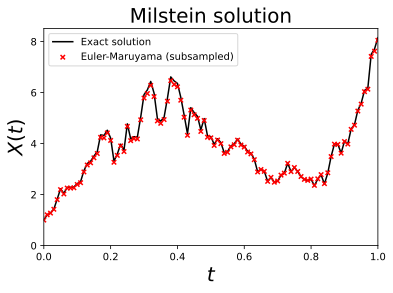

In [135]:
plt.plot(t, X_exact[0, :], color='k', zorder=1, label='Exact solution')
plt.scatter(t, X[0, :], s=20, marker='x', color='red', zorder=2, label='Euler-Maruyama (subsampled)')
plt.legend()
plt.xlim([0, T])
plt.xticks(np.linspace(0, 1, 6))
plt.yticks(np.linspace(0, 8, 5))
plt.title('Milstein solution', fontsize=20)
plt.xlabel(r'$t$', fontsize=20)
plt.ylabel(r'$X(t)$', fontsize=20)
plt.show()

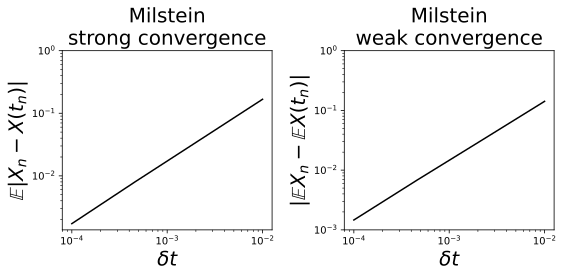

In [136]:
# Black-Scholes parameters
lamda = 2
mu = 1

# Seed and integration parameters
seed = 0
X0 = 1
T = 1
Ns = (10 ** np.linspace(2, 4, 4)).astype(dtype=np.int)
num_paths = int(1e4)

# Get drift and diffusion functions of the Black-Scholes model
f, g = f_g_black_scholes(lamda=lamda, mu=mu)

dts = []
X_approx = []
X_exacts = []

for N in Ns:
    
    t, X, W = parallel_milstein(seed=seed, num_paths=num_paths, X0=X0, T=T, N=N, f=f, g=g)
    X_exact = exact_black_scholes(X0=X0, t=t[None, :], W=W, lamda=lamda, mu=mu)
    
    dts.append(T / N)
    X_approx.append(X[:, -1])
    X_exacts.append(X_exact[:, -1])
    
X_approx = np.stack(X_approx, axis=0)
X_exacts = np.stack(X_exacts, axis=0)

X_abs_diffs = np.abs(X_approx - X_exacts)
milstein_strong_errors = np.mean(X_abs_diffs, axis=1)

X_approx_means = np.mean(X_approx, axis=-1)
X_exacts_means = np.mean(X_exacts, axis=-1)
milstein_weak_errors = np.abs(X_approx_means - X_exacts_means)

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.plot(dts, milstein_strong_errors, color='k')

plt.loglog()
plt.yticks([1e-2, 1e-1, 1e0])
plt.xlabel(r'$\delta t$', fontsize=20)
plt.ylabel(r'$\mathbb{E}|X_n - X(t_n)|$', fontsize=20)
plt.title('Milstein\nstrong convergence', fontsize=20)

plt.subplot(122)
plt.plot(dts, milstein_weak_errors, color='k')

plt.loglog()
plt.yticks([1e-3, 1e-2, 1e-1, 1e0])
plt.xlabel(r'$\delta t$', fontsize=20)
plt.ylabel(r'$|\mathbb{E}X_n - \mathbb{E}X(t_n)|$', fontsize=20)
plt.title('Milstein\nweak convergence', fontsize=20)

plt.tight_layout()
plt.show()

## Stochastic chain rule

Suppose we want to evaluate a function $V(\cdot)$ at various $X(t)$, i.e. $V(X(t))$. If $X(t)$ were a deterministic quantity, such as the solution to an ODE, we could solve for $X(t)$ and plug it into $V$. Alternatively, we could express the evolution of $V$ itself as a differential equation using the chain rule:

\begin{align}
dV &= \frac{dV}{dX}dX = \frac{dV}{dX} f(t) dt, \text{ where } dX = f(t) dt,\\
\end{align}

This way, we could solve the following ODE directly for $V$

\begin{align}
\frac{dV}{dt} &= \frac{dV}{dX} f(t).
\end{align}

For an autonomous SDE however the chain rule takes a different form, which under the Ito definition is as follows.

<div class="theorem">
    
**Definition (Ito's result for one dimension)** Let $X_t$ be an Ito process given by

\begin{align}
    dX_t = U_t dt + H_t dW_t.
\end{align}
    
where $U_t, H_t$ are square-integrable processes, and let $V(X, t)$ be a twice continuously differentiable function. Then $Y_t = V(X_t, t)$ is again an Ito process and
    
\begin{align}
    dY_t = \frac{\partial V}{\partial t} dt + \frac{\partial V}{\partial X} dX_t + \frac{1}{2}\frac{\partial^2 V}{\partial X^2} H_t^2 dt. 
\end{align}
    
If $V$ does not depend on $t$, we have
    
\begin{align}
    dY_t = \left(\frac{\partial V}{\partial X} U_t + \frac{1}{2}\frac{\partial^2 V}{\partial X^2} H_t^2 \right) dt + \frac{\partial V}{\partial X}H_t dW_t. 
\end{align}
    
</div>
<br>

For a more formal definition and proof of Ito's result see {cite}`oksendal` (Theorem 4.1.8 and pages 44-48). Below is a short sketch proof, which highlights why the additional term appears in the formula.

<details class="proof">
<summary>Informal argument: Ito's result for one dimension</summary>

<div>
    
Writing the infinitesimal difference in $Y_t$ as a Taylor expansion we get
\begin{align}
    dY_t = \frac{\partial V}{\partial t} dt + \frac{\partial V}{\partial X} dX_t + \frac{1}{2} \left[\frac{\partial^2 V}{\partial X^2} dX_t^2 + 2 \frac{\partial^2 V}{\partial X \partial t} dt dX_t + \frac{\partial^2 V}{\partial t^2} dt^2 \right] + o(dt^2),
\end{align}
where the $o(dt^n)$ notation means that the ratio of the term being ommited, to the infinitesimal $dt^n$ goes to 0 as $dt \to 0$. Now since $dX_t = U_t dt + H_t dW_t$ and $dW_t$ is of order $dt^{1/2}$, the last two terms in the square brackets are $o(dt^{3/2})$ and we can neglect them. The reference provides a formal argument for neglecting these terms, showing that their contribution to the Ito integral has zero mean and a variance that tends to 0 as $dt \to 0$ - these contributions converge to $0$ in the sense of mean square convergence.
    
However, the first term is of order $dt$ and does not vanish. In particular
\begin{align}
    dX_t^2 = U_t^2 dt^2 + 2 U_tH_t dW_t dt + H_t^2 dW_t^2.
\end{align}
In the above expression, we can neglect the first two terms which are of order $dt^{3/2}$ and larger. Again, here the formal argument is that their associated contributions to the Ito integral converge to 0 in mean square. This yields the expression
\begin{align}
    dY_t = \frac{\partial V}{\partial X} U_t dt + \frac{1}{2}\frac{\partial^2 V}{\partial X^2} H_t^2 dW_t^2 + \frac{\partial V}{\partial X}H_t dW_t. 
\end{align}
Now consider the contribution to the Ito integral of the last term, i.e. the sum
\begin{align}
    \sum_{n = 1}^N \frac{\partial^2 V}{\partial X^2}\Bigg \vert_{X_{t_n}} H_{t_n}^2 dW_{t_n}^2 = \sum_{n = 1}^N a_n dW_{t_n}^2,
\end{align}
where $t_n = n~dt$ and $N = T / dt$. This sum has expectation $\sum_{n = 1}^N a_n dt$ and it can be shown that its variance goes to 0 as $dt \to 0$, so the contribution converges to $\sum_{n = 1}^N a_n dt$ in mean square and we can write
\begin{align}
    dY_t = \left(\frac{\partial V}{\partial X} U_t + \frac{1}{2}\frac{\partial^2 V}{\partial X^2} H_t^2 \right) dt + \frac{\partial V}{\partial X}H_t dW_t. 
\end{align}

    
 
</div>

</details>
<br>

With this corrected rule, we can directly integrate the stochastic process in question.

## References

```{bibliography} ./num-sde-ref.bib
```